Responsabilidades:
- Simular la respuesta al escalón de Gcl(s) con los valores hallados.
- Implementar el PID en el script de TempLABUdeA.
- Realizar la prueba práctica, recolectar los datos de temperatura y control.
- Comparar los datos experimentales con la simulación (gráficas, %OS, Ts).

Entregables:
- Código de simulación y control.
- Archivos CSV de los datos experimentales.
- Gráficas comparativas: simulación vs experimento.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import ipywidgets as widgets
from ipywidgets import interact

## Simulacion de la respuesta al escalón de Gcl(s).

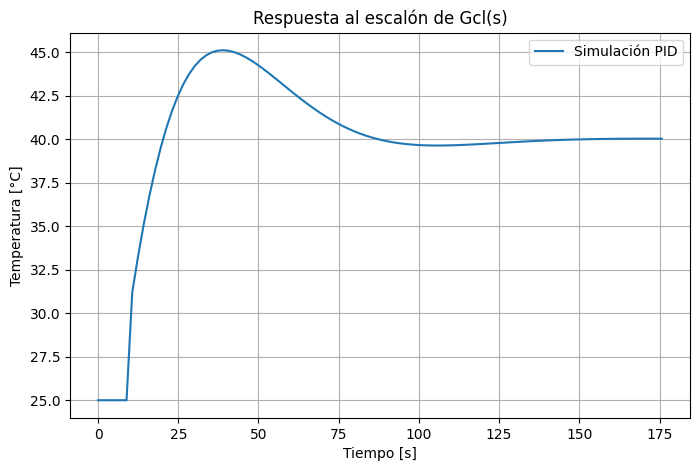


Parámetros:
RiseTime : 15.9711200040868
SettlingTime : 76.30646224174804
SettlingMin : 0.9180862452286489
SettlingMax : 1.1276759067056266
Overshoot : 12.767590670562656
Undershoot : 0
Peak : 1.1276759067056266
PeakTime : 39.040515565545505
SteadyStateValue : 1.0


In [20]:
K = 0.3593
tm = 10
tau = 171.7428
Kp = (1.2 * tau) / (K * tm)
Ti = 2 * tm
Td = 0.5 * tm
L =ctl.tf([Kp*K*Ti*Td, Kp*K*Ti, Kp*K],[Ti*tau, Ti, 0])
Gcl = ctl.feedback(L, 1)
t, y = ctl.step_response(Gcl)
y = y*40
for i in range(len(t)):
  if t[i] < 10:
    y[i] = 25
  else:
    break
plt.figure(figsize=(8, 5))
plt.plot(t, y, label='Simulación PID')
plt.title('Respuesta al escalón de Gcl(s)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()

S2 = ctl.step_info(Gcl)
print("\nParámetros:")
for i in S2:
  print(i,":",S2[i])

## Implementación en TempLABUdeA y recolectar datos.

Selecciona el tipo de controlador:
1 - Control Proporcional-Derivativo (PD)
2 - Control Proporcional-Integral (PI)
3 - Control Proporcional-Integral-Derivativo (PID)
TCLab version 1.0.0
unknown device connected on port COM4 at 115200 baud.
TCLab Firmware 1.0.1 Arduino Uno.
Iniciando control PID...


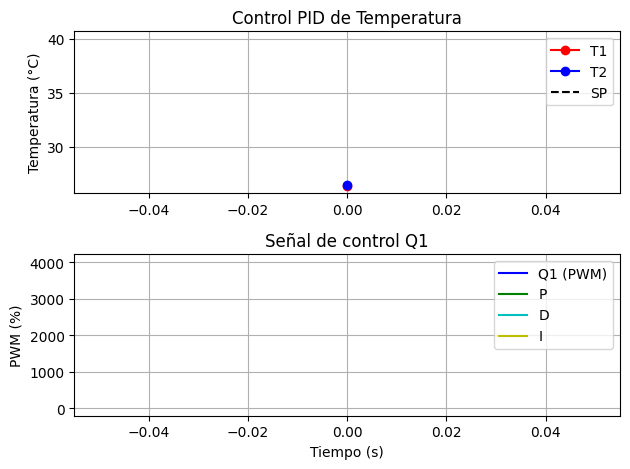

Iteración 0: T1=26.39°C, Q1=0.00%


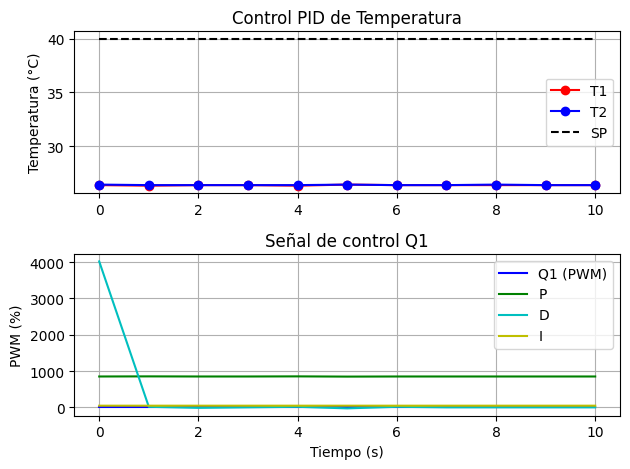

Iteración 10: T1=26.39°C, Q1=0.00%


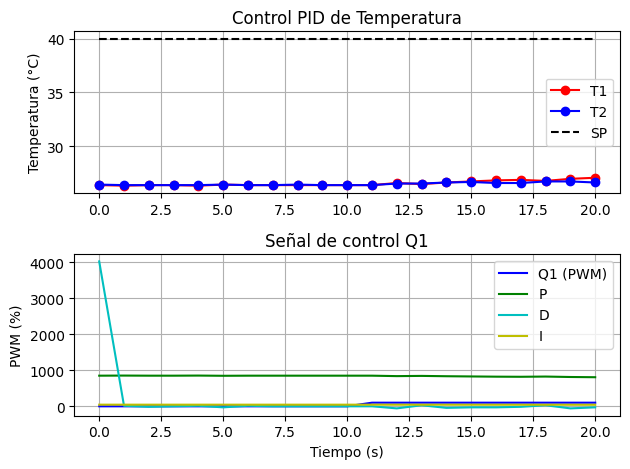

Iteración 20: T1=27.08°C, Q1=100.00%


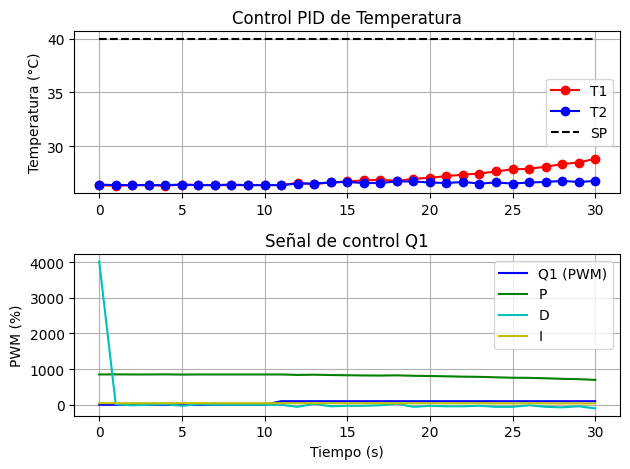

Iteración 30: T1=28.84°C, Q1=100.00%


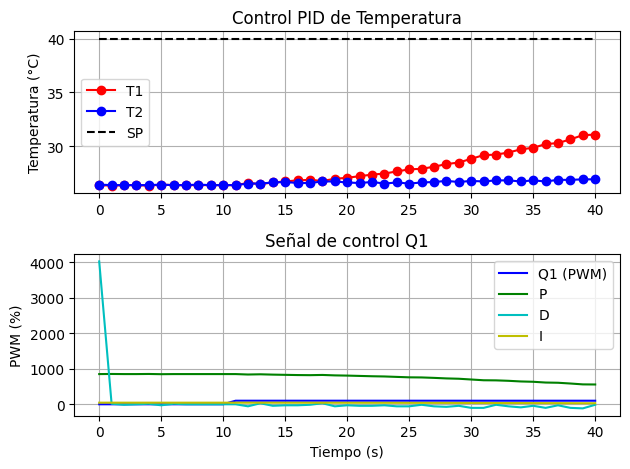

Iteración 40: T1=31.09°C, Q1=100.00%


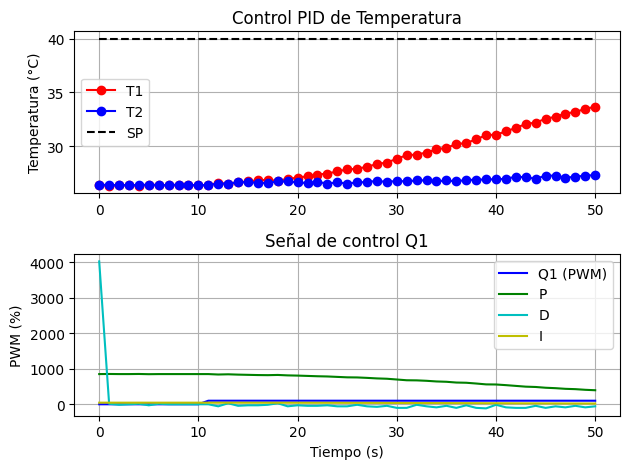

Iteración 50: T1=33.67°C, Q1=100.00%


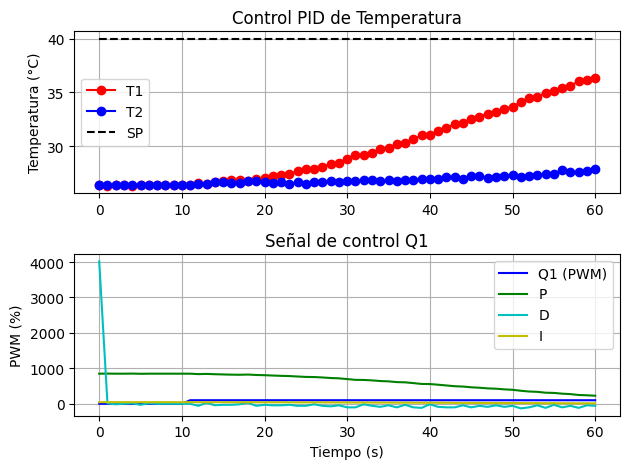

Iteración 60: T1=36.36°C, Q1=100.00%


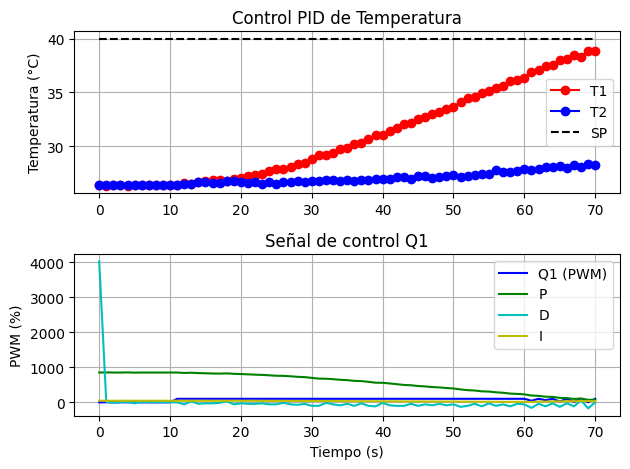

Iteración 70: T1=38.86°C, Q1=100.00%


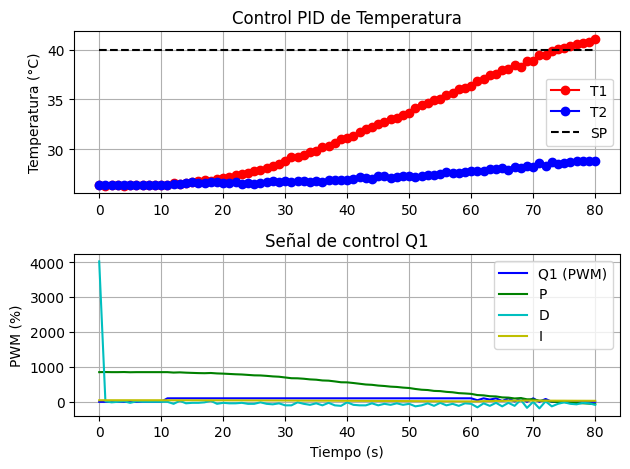

Iteración 80: T1=41.10°C, Q1=0.00%


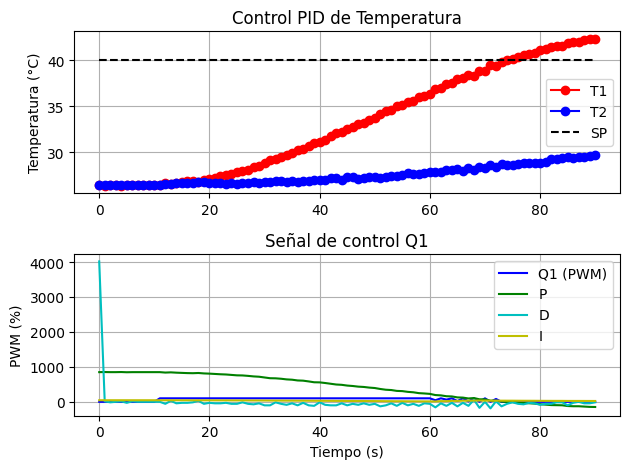

Iteración 90: T1=42.38°C, Q1=0.00%


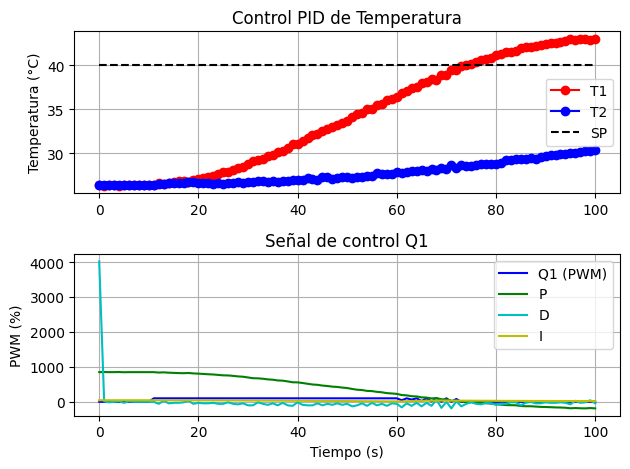

Iteración 100: T1=43.01°C, Q1=0.00%


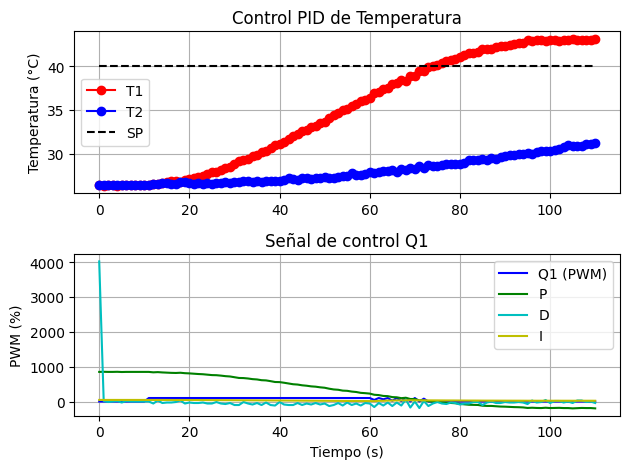

Iteración 110: T1=43.16°C, Q1=0.00%


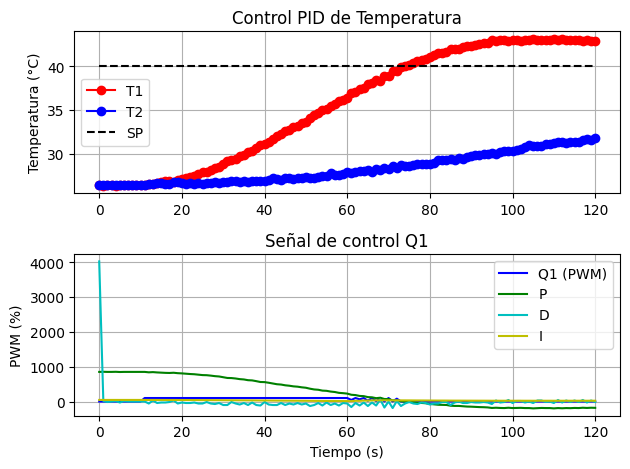

Iteración 120: T1=42.91°C, Q1=0.00%


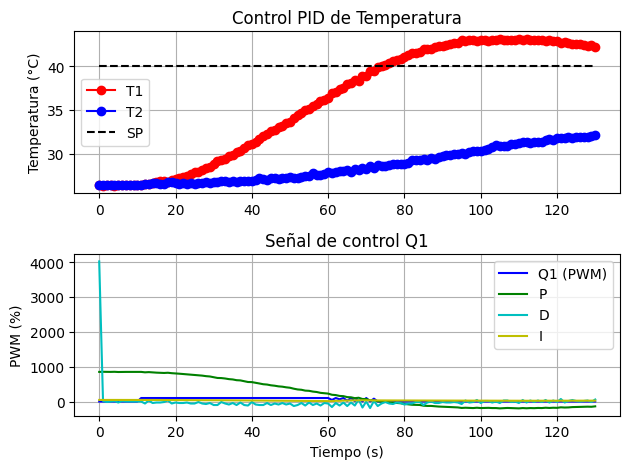

Iteración 130: T1=42.23°C, Q1=0.00%


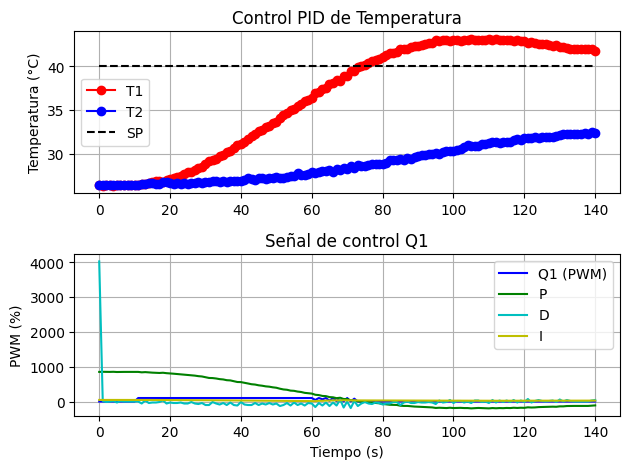

Iteración 140: T1=41.79°C, Q1=0.00%


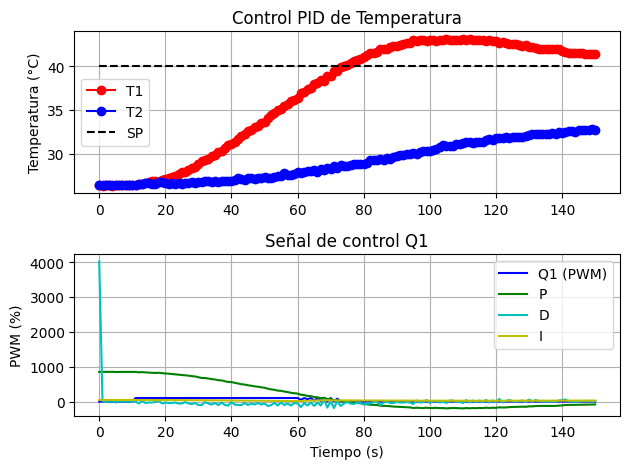

Iteración 150: T1=41.35°C, Q1=0.00%


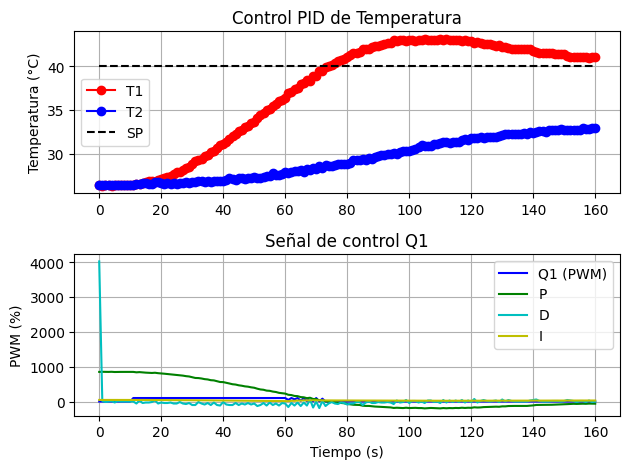

Iteración 160: T1=41.01°C, Q1=0.00%


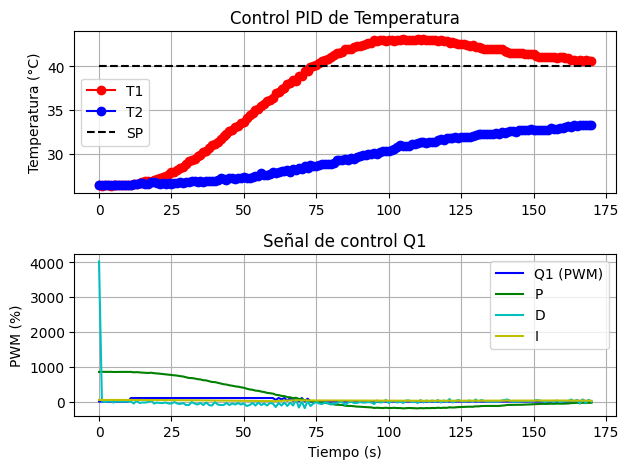

Iteración 170: T1=40.57°C, Q1=0.00%


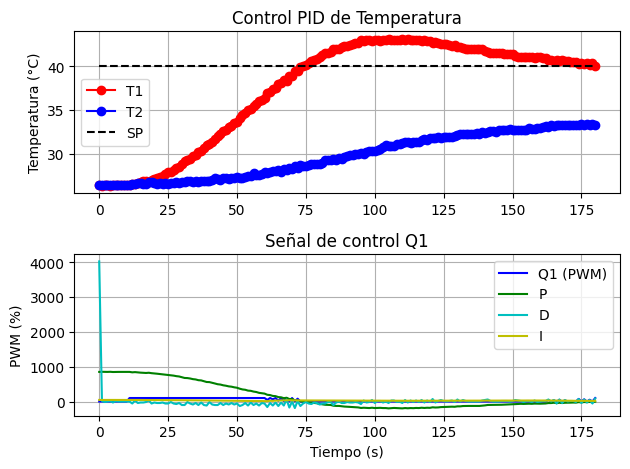

Iteración 180: T1=40.08°C, Q1=99.76%


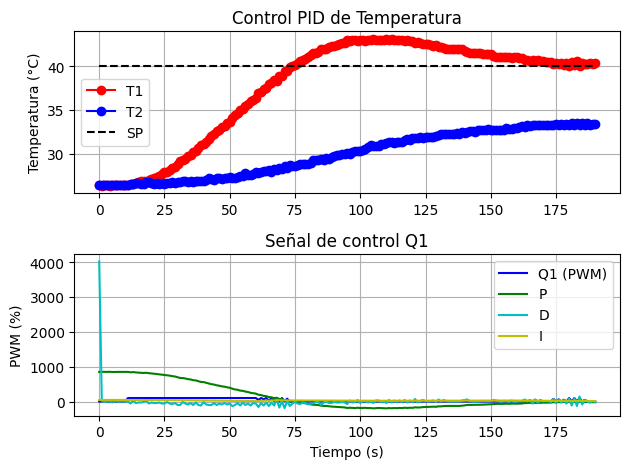

Iteración 190: T1=40.32°C, Q1=0.00%


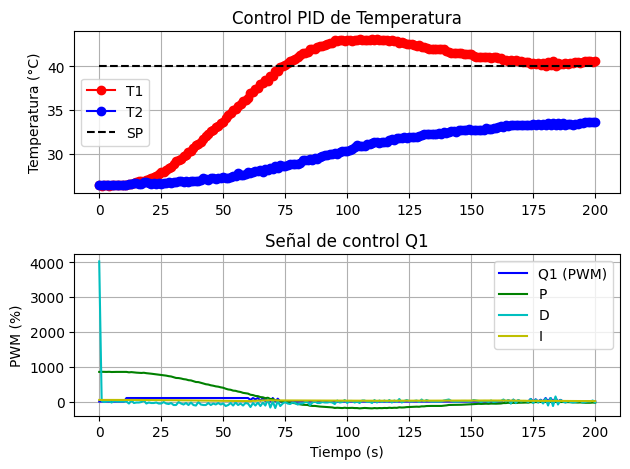

Iteración 200: T1=40.57°C, Q1=0.00%


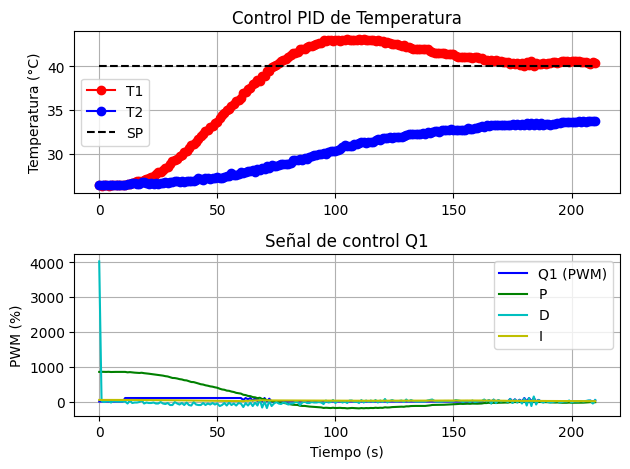

Iteración 210: T1=40.32°C, Q1=32.56%


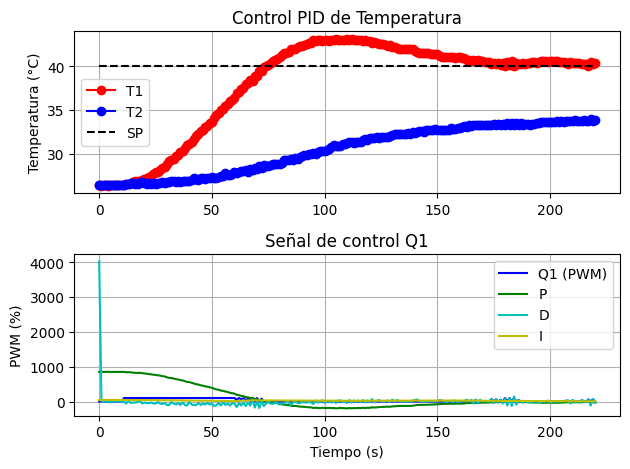

Iteración 220: T1=40.37°C, Q1=0.00%


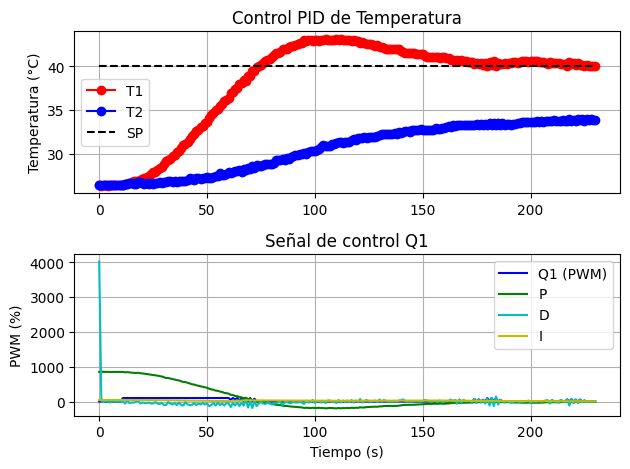

Iteración 230: T1=40.08°C, Q1=0.00%


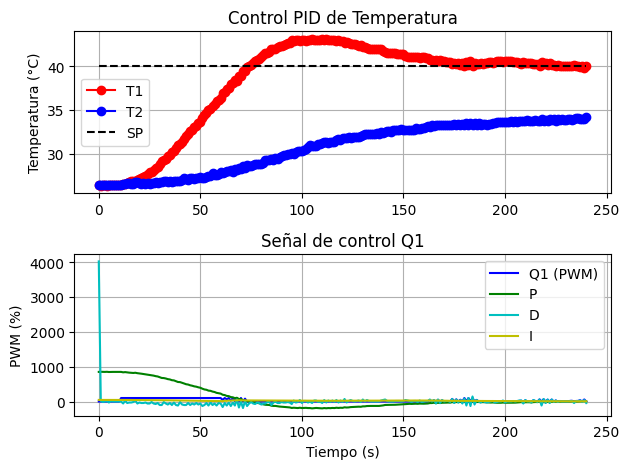

Iteración 240: T1=39.98°C, Q1=0.00%


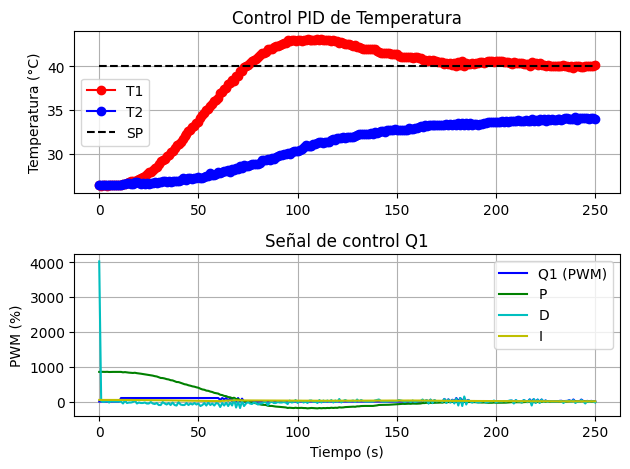

Iteración 250: T1=40.13°C, Q1=0.00%


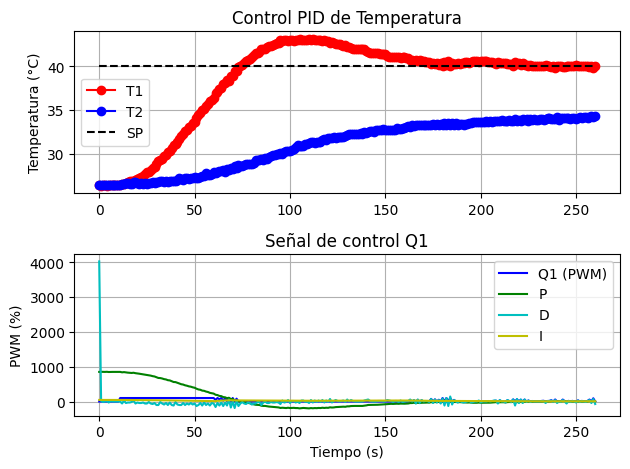

Iteración 260: T1=40.03°C, Q1=0.00%


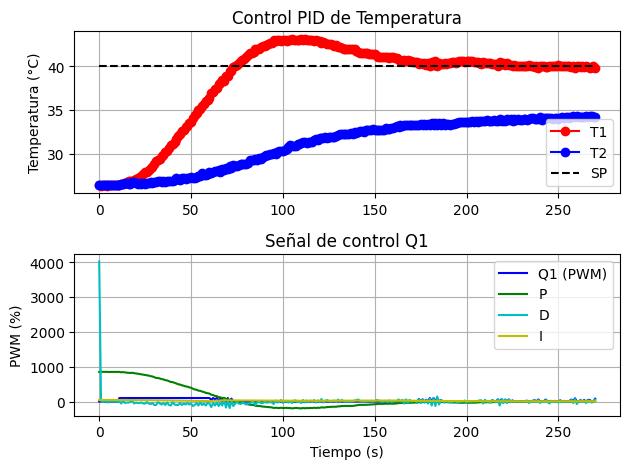

Iteración 270: T1=39.78°C, Q1=79.57%


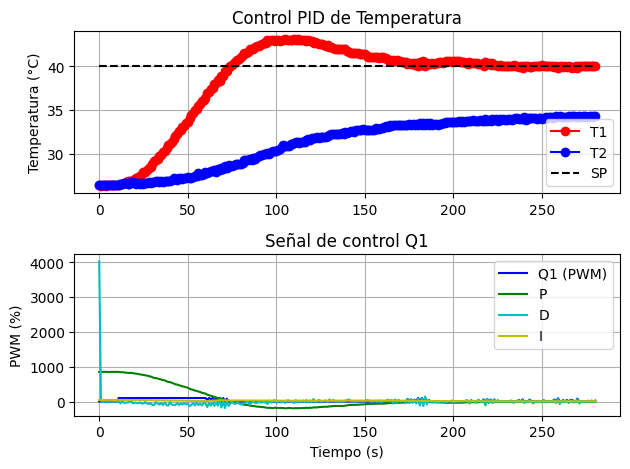

Iteración 280: T1=39.98°C, Q1=24.36%


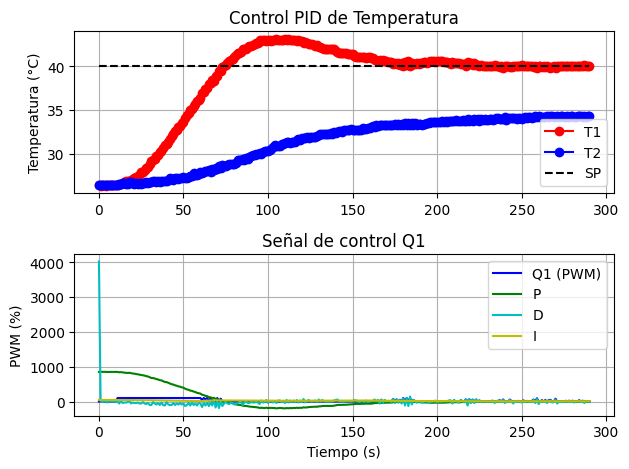

Iteración 290: T1=40.08°C, Q1=2.63%


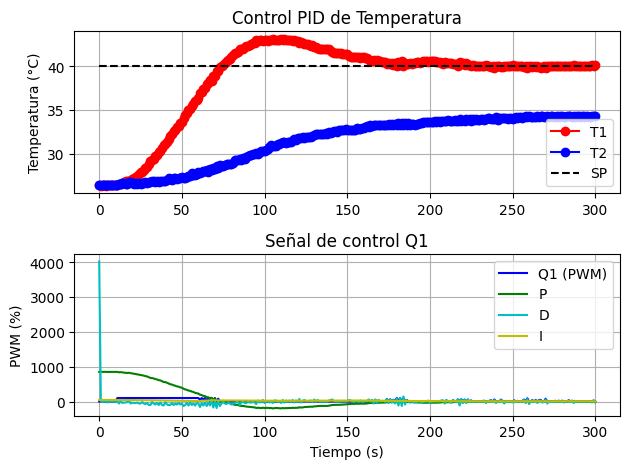

Iteración 300: T1=40.18°C, Q1=0.00%


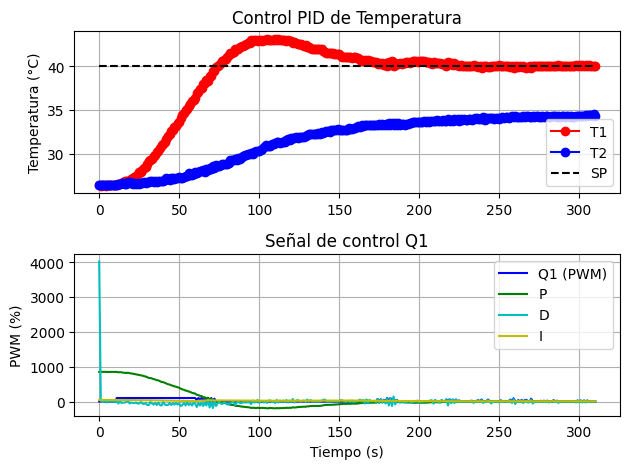

Iteración 310: T1=40.08°C, Q1=0.00%


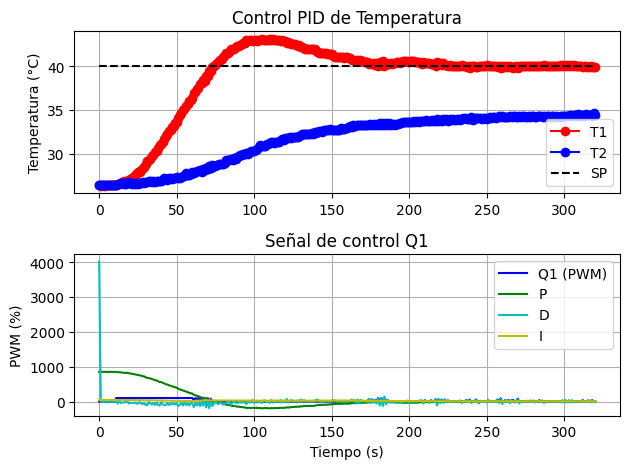

Iteración 320: T1=39.93°C, Q1=10.06%


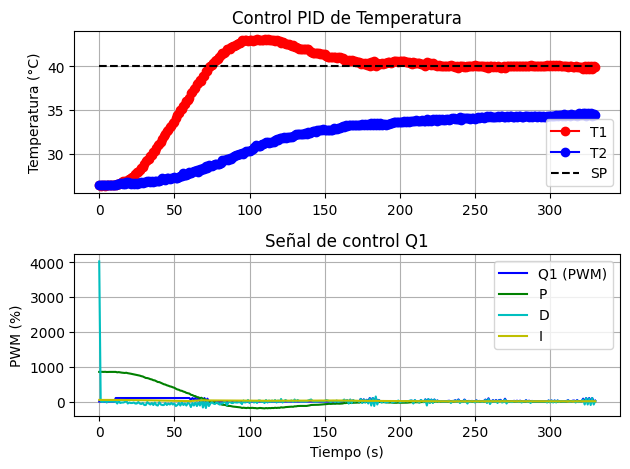

Iteración 330: T1=39.93°C, Q1=25.56%


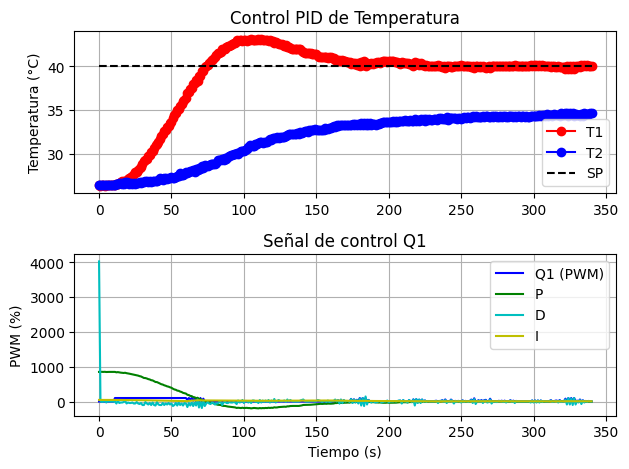

Iteración 340: T1=40.08°C, Q1=1.53%


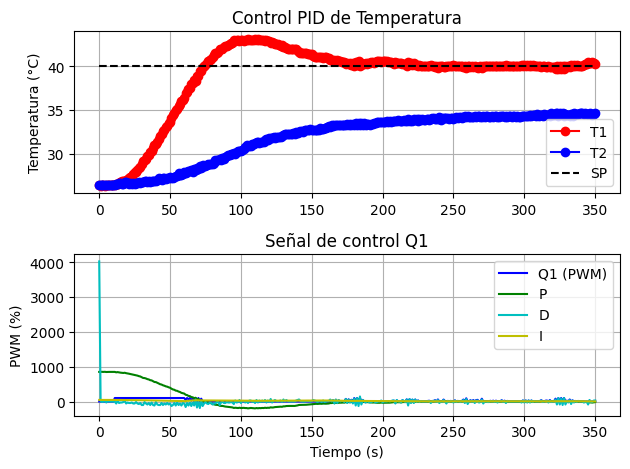

Iteración 350: T1=40.27°C, Q1=14.34%


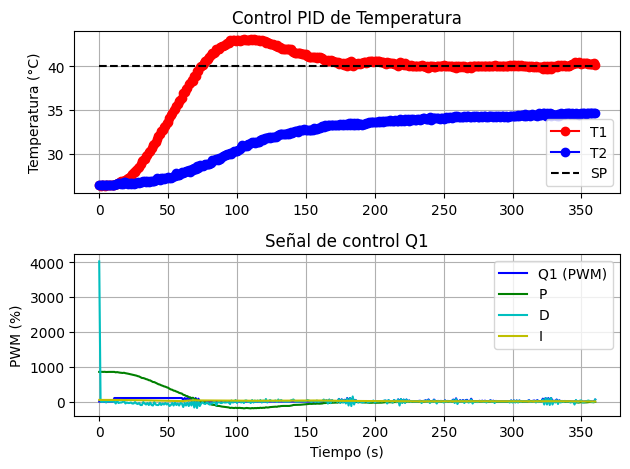

Iteración 360: T1=40.13°C, Q1=50.69%


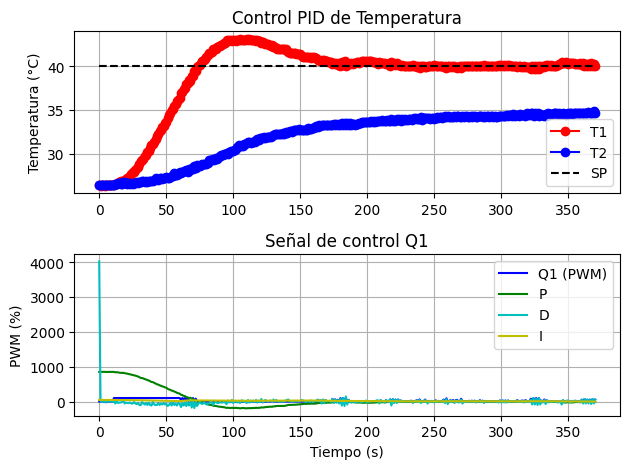

Iteración 370: T1=40.08°C, Q1=52.46%


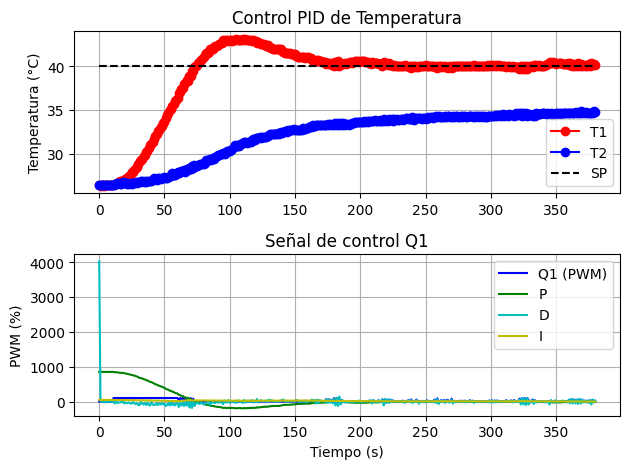

Iteración 380: T1=40.18°C, Q1=15.47%


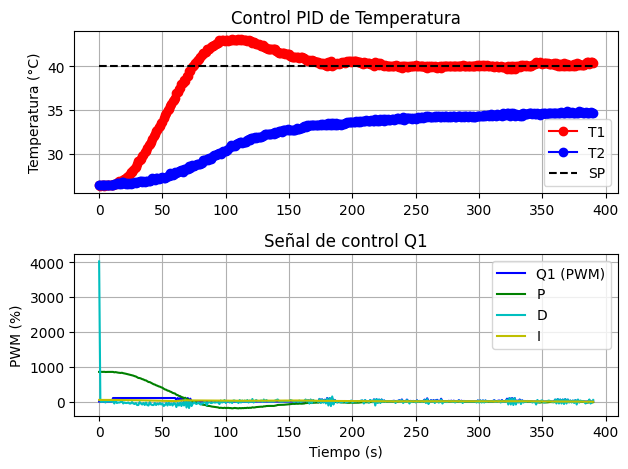

Iteración 390: T1=40.32°C, Q1=18.09%


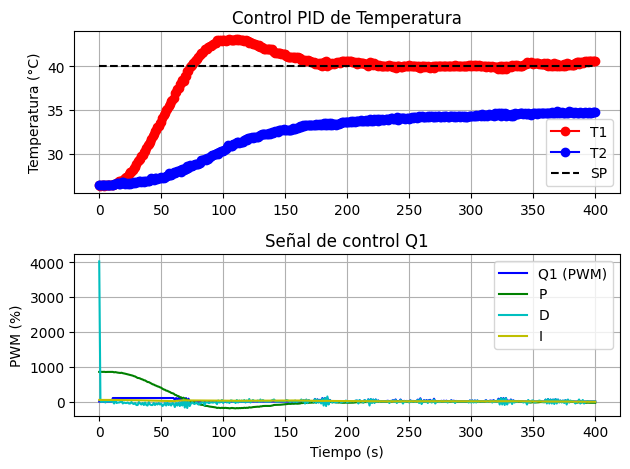

Iteración 400: T1=40.57°C, Q1=0.00%


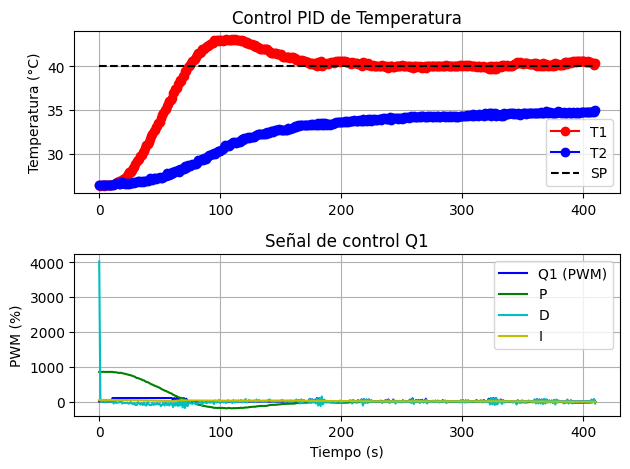

Iteración 410: T1=40.32°C, Q1=0.00%


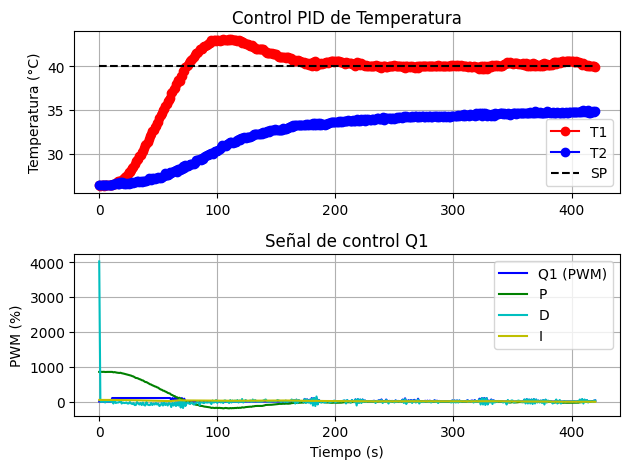

Iteración 420: T1=39.88°C, Q1=29.17%


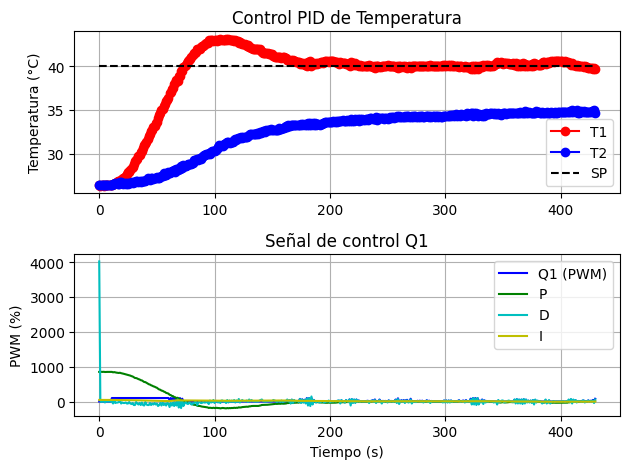

Iteración 430: T1=39.64°C, Q1=78.66%


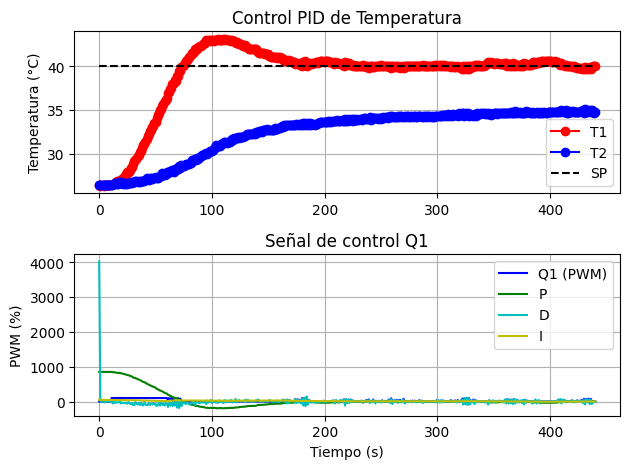

Iteración 440: T1=40.03°C, Q1=0.00%


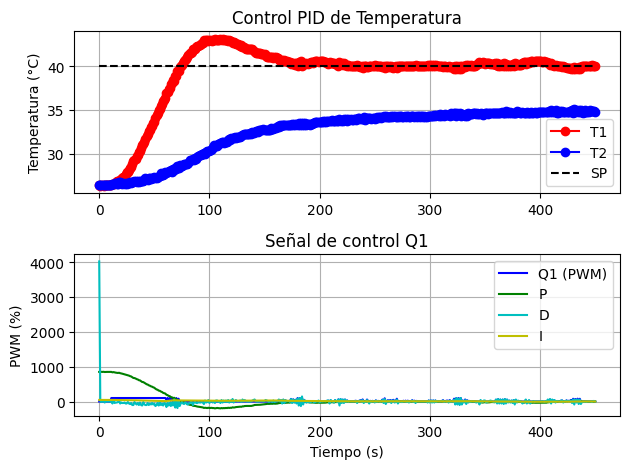

Iteración 450: T1=40.03°C, Q1=0.00%


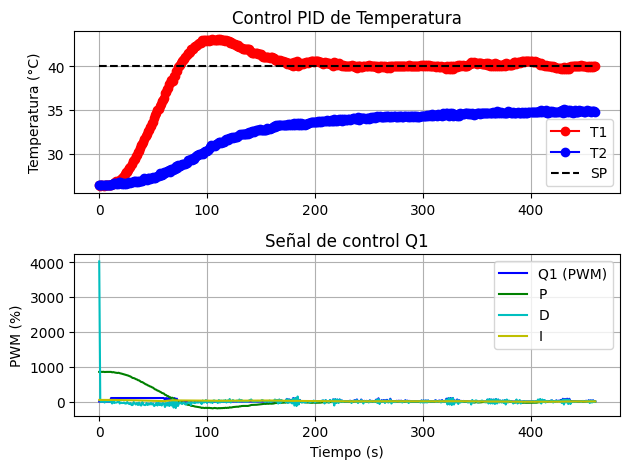

Iteración 460: T1=39.98°C, Q1=3.44%


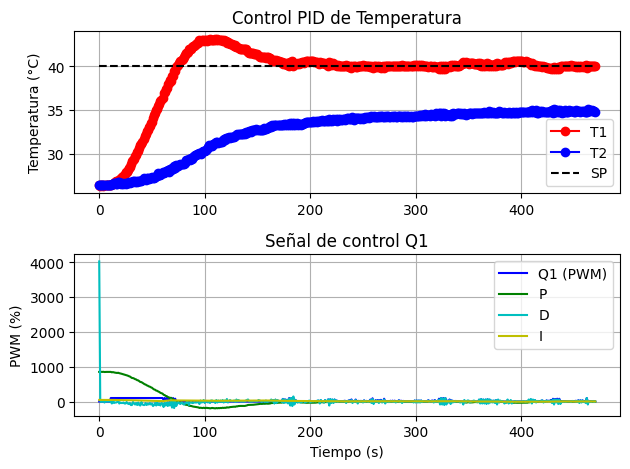

Iteración 470: T1=40.08°C, Q1=0.00%


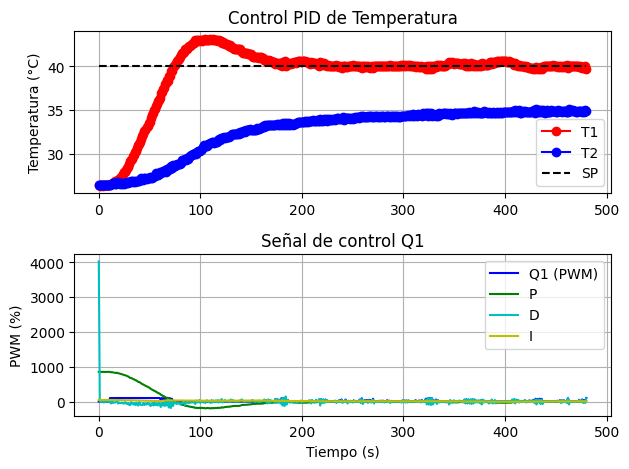

Iteración 480: T1=39.69°C, Q1=100.00%


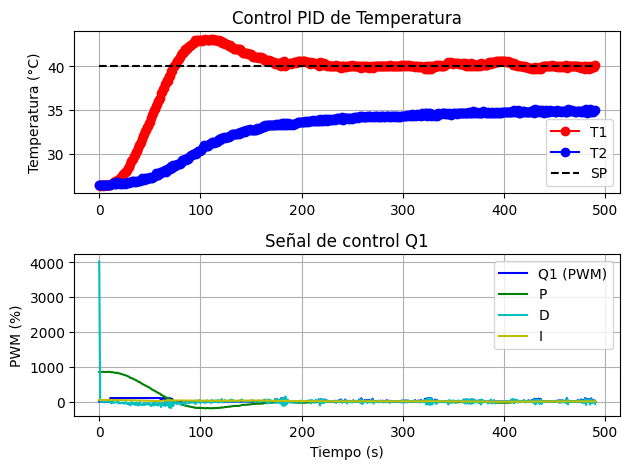

Iteración 490: T1=40.18°C, Q1=0.00%


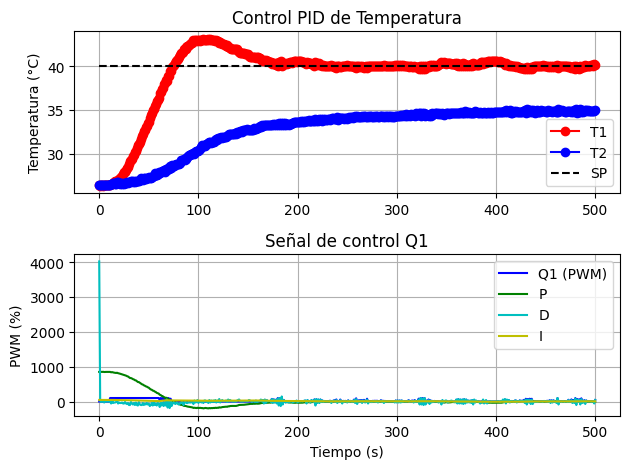

Iteración 500: T1=40.13°C, Q1=39.90%


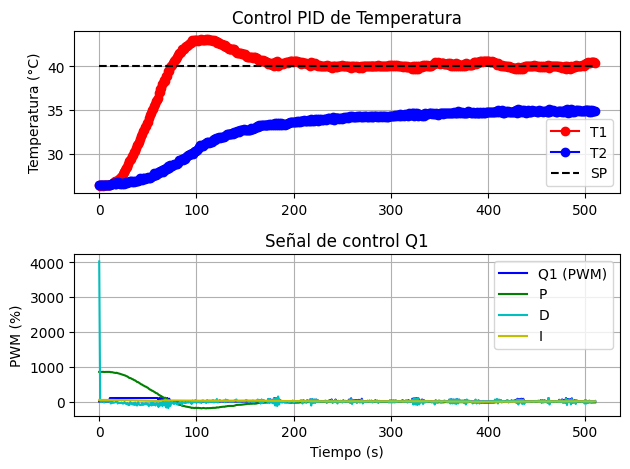

Iteración 510: T1=40.42°C, Q1=0.00%


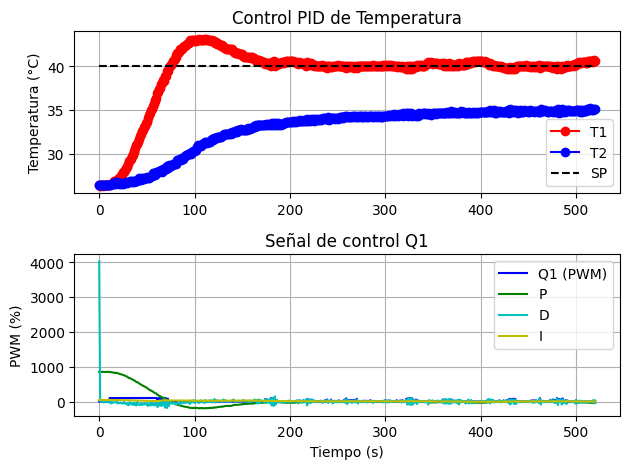

Iteración 520: T1=40.57°C, Q1=0.00%


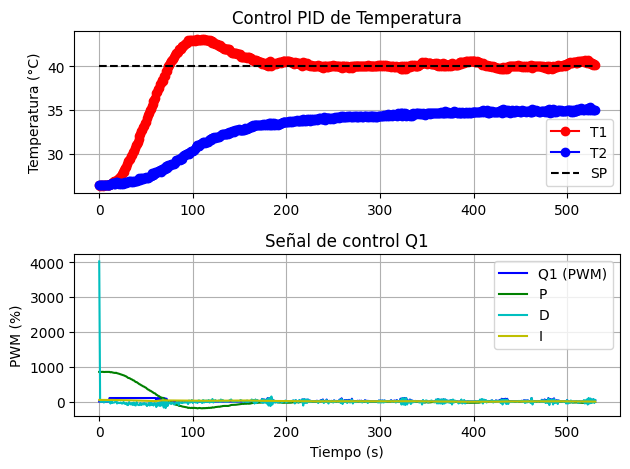

Iteración 530: T1=40.13°C, Q1=33.26%


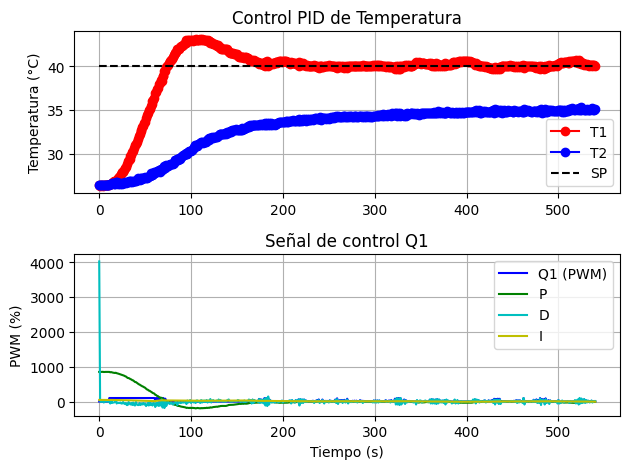

Iteración 540: T1=40.08°C, Q1=5.77%


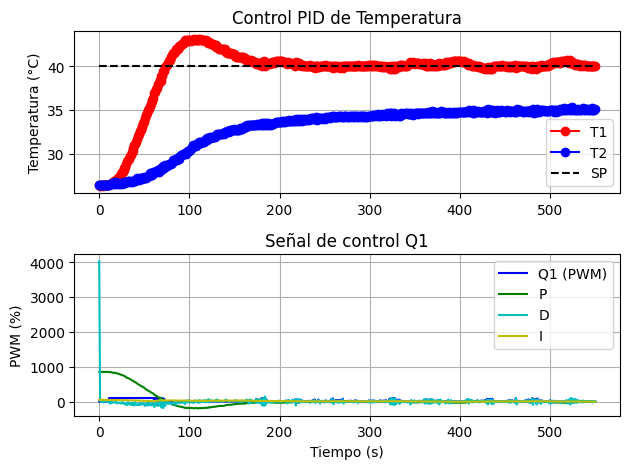

Iteración 550: T1=40.03°C, Q1=8.61%


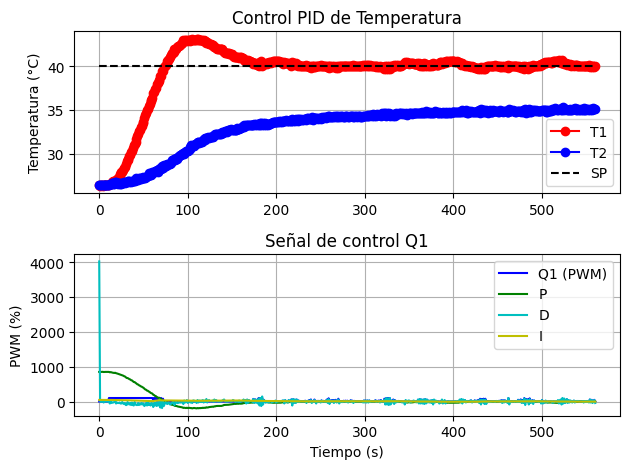

Iteración 560: T1=40.03°C, Q1=0.00%


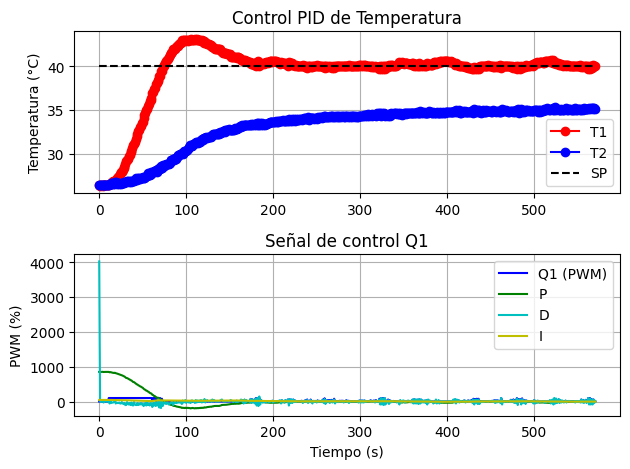

Iteración 570: T1=40.03°C, Q1=10.18%


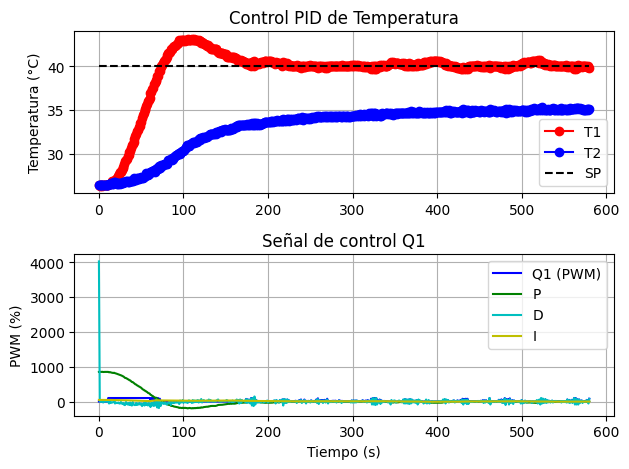

Iteración 580: T1=39.83°C, Q1=81.22%


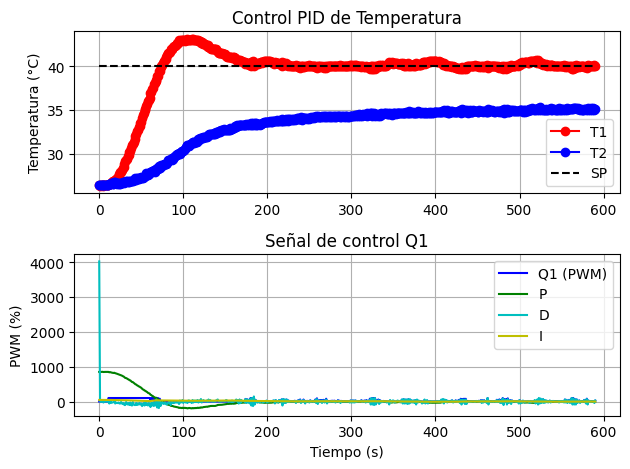

Iteración 590: T1=40.08°C, Q1=22.34%


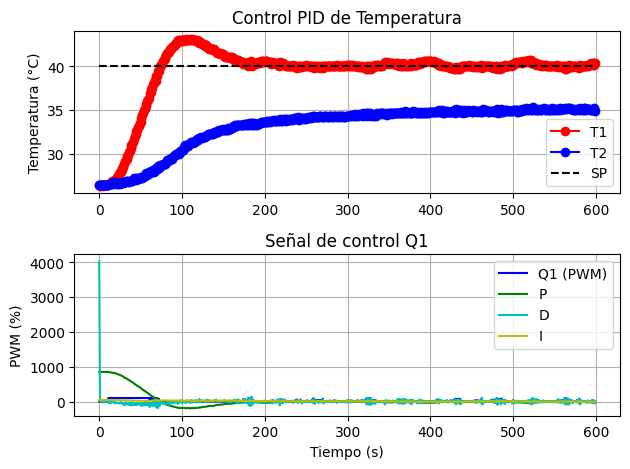

Iteración 599: T1=40.42°C, Q1=0.00%
TCLab disconnected successfully.
Datos guardados en 'registro_PID_TempLab_2025-06-09_17-38-41.csv'
Gráfica guardada en 'grafico_PID_TempLab_2025-06-09_17-38-41.png'


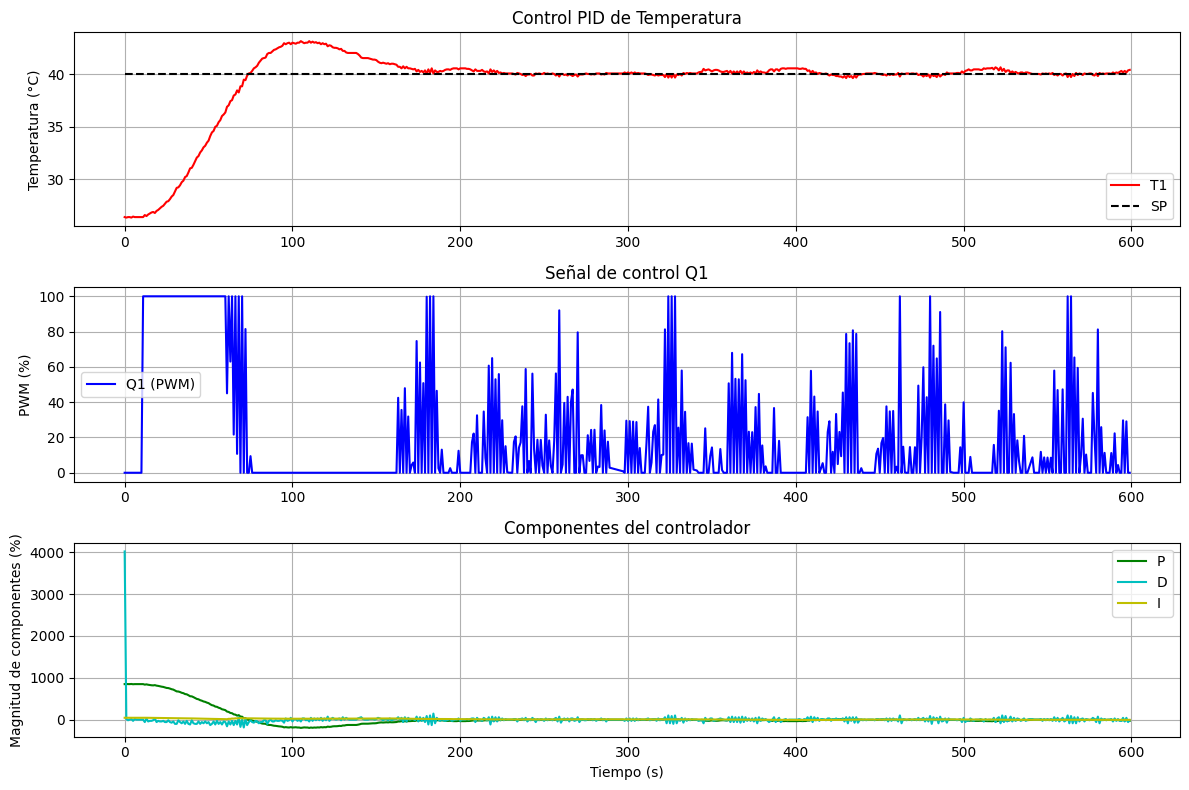

In [1]:
import tclab 
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# ------------------------------------------------------------------------------
# Función para permitir seleccionar el tipo de controlador
def ejecutar_control(tipo_controlador='PID'):
    """
    Ejecuta el control de temperatura con el tipo de controlador seleccionado
    tipo_controlador: 'PD', 'PI', o 'PID'
    """
    lab = tclab.TCLab()
    
    # Parámetros de control
    Kc = 62.4  # Ganancia proporcional
    tauI = 18.9295  # Tiempo integral
    tauD = 4.7324  # Tiempo derivativo
    Q_bias = 0.0  # Bias
    ierr = 0.0  # Error integral acumulado
    prev_err = 0.0  # Error anterior (para término derivativo)
    
    # Inicializar listas
    n = 600  # Número de muestras
    T1 = [0.0] * n  # Temperatura en sensor 1
    T2 = [0.0] * n  # Temperatura en sensor 2
    Q1 = [0.0] * n  # Señal de control para calentador 1
    SP1 = [40.0] * n  # Setpoint (temperatura deseada)
    
    # Para almacenar los componentes del controladors
    P_component = [0.0] * n  # Componente proporcional
    I_component = [0.0] * n  # Componente integral
    D_component = [0.0] * n  # Componente derivativo
    
    # Configurar la gráfica en modo interactivo
    plt.ion()
    
    try:
        print(f"Iniciando control {tipo_controlador}...")
        for i in range(n):
            # Leer temperatura actual
            T1[i] = lab.T2
            T2[i] = lab.T1
            
            # Cálculo del error
            err = SP1[i] - T1[i]
            
            # Componente proporcional - siempre se usa
            P_component[i] = Kc * err
            
            # Componente integral - solo para PI y PID
            if tipo_controlador in ['PI', 'PID']:
                ierr += err
                I_component[i] = (Kc / tauI) * ierr
            
            # Componente derivativo - para PD y PID
            if tipo_controlador in ['PD', 'PID']:
                deriv = (err - prev_err)
                D_component[i] = Kc * tauD * deriv
                prev_err = err
            
            # Calcular la acción de control según el tipo de controlador
            if tipo_controlador == 'PD':
                Q1[i] = Q_bias + P_component[i] + D_component[i]
            elif tipo_controlador == 'PI':
                Q1[i] = Q_bias + P_component[i] + I_component[i]
            else:  # PID
                Q1[i] = Q_bias + P_component[i] + I_component[i] + D_component[i]
            
            # Anti-windup
            if Q1[i] >= 100:
                Q1[i] = 100
                if tipo_controlador in ['PI', 'PID']:
                    ierr -= err  # Corregir el error integral acumulado
            elif Q1[i] <= 0:
                Q1[i] = 0
                if tipo_controlador in ['PI', 'PID']:
                    ierr -= err  # Corregir el error integral acumulado
            
            # Aplicar señal de control
            if i > 10:
                lab.Q1(Q1[i])
            else:
                Q1[i] = 0.0
                lab.Q1(0)
            
            # Para actualizar cada 10 segundos pero seguir muestreando cada segundo:
            # 1. Solo actualizamos la gráfica cada 10 iteraciones
            # 2. Pero seguimos tomando muestras y aplicando control cada iteración
            
            if i % 10 == 0 or i == n-1:  # Actualizar gráfica cada 10 segundos o en la última iteración
                # Gráfica de temperatura
                plt.clf()
                plt.subplot(2, 1, 1)
                plt.plot(T1[:i+1], 'r-o', label='T1')
                plt.plot(T2[:i+1], 'b-o', label='T2')
                plt.plot(SP1[:i+1], 'k--', label='SP')
                plt.ylabel('Temperatura (°C)')
                plt.title(f'Control {tipo_controlador} de Temperatura')
                plt.grid(True)
                plt.legend()
                
                # Gráfica de PWM (Q1)
                plt.subplot(2, 1, 2)
                plt.plot(Q1[:i+1], 'b-', label='Q1 (PWM)')
                
                # También graficar los componentes del controlador
                plt.plot(P_component[:i+1], 'g-', label='P')
                
                if tipo_controlador in ['PD', 'PID']:
                    plt.plot(D_component[:i+1], 'c-', label='D')
                    
                if tipo_controlador in ['PI', 'PID']:
                    plt.plot(I_component[:i+1], 'y-', label='I')
                
                plt.ylabel('PWM (%)')
                plt.title('Señal de control Q1')
                plt.xlabel('Tiempo (s)')
                plt.grid(True)
                plt.legend()
                
                plt.tight_layout()
                plt.pause(0.05)  # Pequeña pausa necesaria para actualizar la gráfica
                print(f"Iteración {i}: T1={T1[i]:.2f}°C, Q1={Q1[i]:.2f}%")
                
            time.sleep(1)  # Esperar un segundo entre muestras
        
    except KeyboardInterrupt:
        # En caso de interrupción, apagar y cerrar conexión
        print("\nDetención por usuario. Apagando calentadores y cerrando conexión.")
    
    finally:
        # Asegurar que siempre se apaguen los calentadores y se cierre la conexión
        lab.Q1(0)
        lab.Q2(0)
        lab.close()
        
        # Guardar resultados
        t = np.arange(n)
        
        # Crear DataFrame con los datos
        data = {
            'Tiempo (s)': t,
            'Setpoint (SP)': SP1,
            'Temperatura (T1)': T1,
            'Control PWM (Q1)': Q1,
            'Componente P': P_component
        }
        
        # Añadir componentes según el controlador usado
        if tipo_controlador in ['PD', 'PID']:
            data['Componente D'] = D_component
        if tipo_controlador in ['PI', 'PID']:
            data['Componente I'] = I_component
        
        df = pd.DataFrame(data)
        
        # Generar timestamp para nombrar los archivos
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        
        # Guardar datos en CSV
        csv_filename = f'registro_{tipo_controlador}_TempLab_{timestamp}.csv'
        df.to_csv(csv_filename, index=False)
        print(f"Datos guardados en '{csv_filename}'")
        
        # Crear gráfica final para guardar como imagen
        plt.figure(figsize=(12, 8))
        
        # Gráfica 1: Temperatura vs Tiempo
        plt.subplot(3, 1, 1)
        plt.plot(t, T1, 'r-', label='T1')
        plt.plot(t, SP1, 'k--', label='SP')
        plt.ylabel('Temperatura (°C)')
        plt.title(f'Control {tipo_controlador} de Temperatura')
        plt.grid(True)
        plt.legend()
        
        # Gráfica 2: Señal de control (PWM) vs Tiempo
        plt.subplot(3, 1, 2)
        plt.plot(t, Q1, 'b-', label='Q1 (PWM)')
        plt.ylabel('PWM (%)')
        plt.title('Señal de control Q1')
        plt.grid(True)
        plt.legend()
        
        # Gráfica 3: Componentes del controlador vs Tiempo
        plt.subplot(3, 1, 3)
        plt.plot(t, P_component, 'g-', label='P')
        if tipo_controlador in ['PD', 'PID']:
            plt.plot(t, D_component, 'c-', label='D')
        if tipo_controlador in ['PI', 'PID']:
            plt.plot(t, I_component, 'y-', label='I')
        plt.ylabel('Magnitud de componentes (%)')
        plt.xlabel('Tiempo (s)')
        plt.title('Componentes del controlador')
        plt.grid(True)
        plt.legend()
        
        # Guardar imagen
        image_filename = f'grafico_{tipo_controlador}_TempLab_{timestamp}.png'
        plt.tight_layout()
        plt.savefig(image_filename)
        print(f"Gráfica guardada en '{image_filename}'")
        
        plt.ioff()  # Desactivar modo interactivo
        plt.show()  # Mostrar la gráfica final
        
        return df  # Retornar el dataframe con los resultados

# Ejemplo de uso:
if __name__ == "__main__":
    print("Selecciona el tipo de controlador:")
    print("1 - Control Proporcional-Derivativo (PD)")
    print("2 - Control Proporcional-Integral (PI)")
    print("3 - Control Proporcional-Integral-Derivativo (PID)")
    
    opcion = input("Ingresa el número de la opción deseada (1, 2 o 3): ")
    
    if opcion == '1':
        ejecutar_control('PD')
    elif opcion == '2':
        ejecutar_control('PI')
    elif opcion == '3':
        ejecutar_control('PID')
    else:
        print("Opción no válida. Ejecutando PID por defecto.")
        ejecutar_control('PID')

## Archivo de datos experimentales (*.csv)

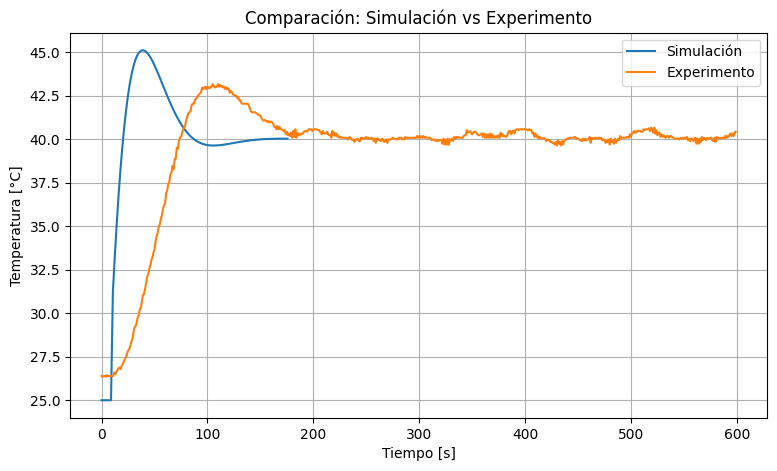

In [21]:
import pandas as pd

# Cargar datos experimentales
df = pd.read_csv("registro_PID_TempLab_2025-06-09_17-38-41.csv")
# Graficar comparación
plt.figure(figsize=(9, 5))
plt.plot(t, y, label="Simulación")
plt.plot(df["Tiempo (s)"], df["Temperatura (T1)"], label="Experimento")
plt.xlabel("Tiempo [s]")
plt.ylabel("Temperatura [°C]")
plt.title("Comparación: Simulación vs Experimento")
plt.grid(True)
plt.legend()
plt.show()